# Redes Neurais e Aprendizado Profundo
SCC0270 - 2/2022


## Trabalho 1 - Redes Densas e Convolucionais

NOME: Felipe Andrade Garcia Tommaselli 

NUSP: 11800910

NOME: Diego Fleury Corrêa De Moraes

NUSP: 11800584

Neste trabalho você deverá implementar duas redes neurais usando Pytorch, uma utilizando camadas densas e outra utilizando camadas convolucionais. Será utilizado o dataset Fashion MNIST.

### Instruções:

- Preencha o nome e o número USP da dupla na célula acima;
- Renomeie o notebook, inserindo o número USP de cada um da dupla, conforme o exemplo: "SCC0270-T1-1234567-7654321";
- Neste notebook, você irá encontrar 5 exercícios, cada um deles valendo uma certa quantidade de pontos. A conclusão de todos os exercícios com sucesso valerá nota 10;
- Responda cada exercício inserindo o código adequado para cada função.
- Envie o notebook inteiro como entrega do exercício.
- Certifique-se de que os códigos executam corretamente, uma vez que a nota só será atribuída caso seja possível executar o código, e ele esteja correto.
- Fraudes ou plágio implica em nota zero e possíveis medidas administrativas.


### Objetivos:

- Compreender como o aprendizado de máquina consegue resolver problemas que métodos tradicionais de programação não conseguem
- Aprender sobre o dataset público Fashion MNIST
- Observar as diferenças do uso de camadas densas e convolucionais

### Imports

In [54]:
from torchvision import datasets, transforms, utils

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [55]:
# Selecionar GPU caso disponível
print("GPU disponível:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

GPU disponível: False


device(type='cpu')

### Dataset Fashion-MNIST

### Dados, Anotações e Subsets

- `train_set`: Imagens usadas para treinar a rede neural. Contém anotações corretas para cada imagem de `train_set`, usado para avaliar as predições do modelo durante a fase de treinamento.
- `test_set`: Imagens usadas para avaliar o desempenho do modelo, uma vez que ele já foi treinado. Contém anotações corretas para cada imagem de `test_set`, usado para avaliar as predições do modelo durante a fase de validação


### Importar dados para a memória

In [56]:
# Fazer o download dos dados

train_set = datasets.FashionMNIST(
    "./data", 
    download=True, 
    train=True, 
    transform=transforms.Compose([transforms.ToTensor()])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

test_set = datasets.FashionMNIST(
    "./data", 
    download=True, 
    train=False, 
    transform=transforms.Compose([transforms.ToTensor()])
) 
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

### Explorando o dataset

In [57]:
# Tamanho do dataset
len(train_set)

60000

In [58]:
# Vamos observar o que é cada loader
example = next(iter(train_loader))
example[0].size()

torch.Size([100, 1, 28, 28])

9


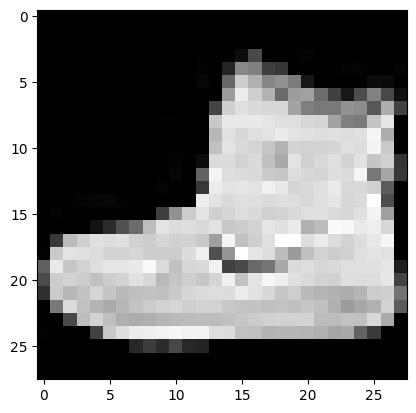

In [59]:
# Uma imagem do train_set, com sua respectiva label
img, label = next(iter(train_set))
plt.imshow(img.squeeze(), cmap="gray")
print(label)

In [60]:
# Função de ajuda para ler o que significa cada label
def convert_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }

    if type(label) == torch.Tensor:
        input = label.item()  
    else:
        input = label

    return output_mapping[input]

1: <class 'torch.Tensor'> <class 'torch.Tensor'>
2: torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

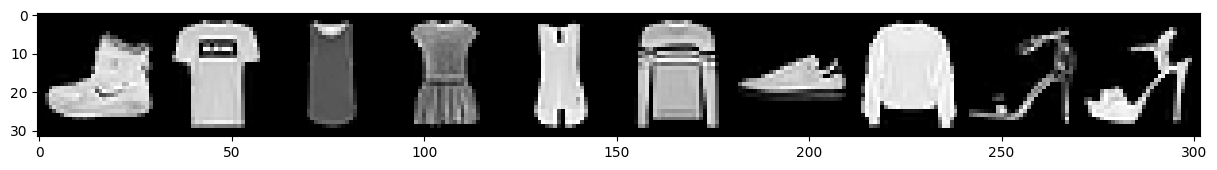

In [61]:
# Vamos observar algumas imagens do Fashion MNIST

demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print('1:', type(images), type(labels))
print('2:', images.shape, labels.shape)

grid = utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(convert_label(label), end=", ")

### Exercício 1 (3 pontos)

**Exercício**: Neste trabalho, será necessário implementar duas arquiteturas distintas de redes neurais. Uma vez que elas estejam implementadas, será necessário executar o laço (loop) de treinamento dos modelos por diversas épocas. Para isso, nesse primeiro exercício, crie uma função genérica, capaz de receber um modelo Pytorch e executar os passos básicos de propagação, cálculo do erro, retropropagação e atualização dos pesos. Essa função será utilizada nos exercícios seguintes para treinar os modelos por você implementados. Implemente o laço de treinamento de um modelo por num_epochs.

**Instruções**:
- Implemente os passos de propagação (forward)
- Realize o cálculo do erro usando um critério genérico fornecido pela assinatura da função
- Inicialize os gradientes a zero
- Implemente o passo de retropropagação do erro (backpropagation)
- Faça um passo de otimização
- DICA: como essas linhas estão englobadas em uma função, utilize os argumentos da função fit(...), de forma genérica


In [62]:
def fit(model, criterion, optimizer, train_loader, test_loader, num_epochs=5):
    model.to(device)
    
    train_losses = []
    test_losses = []
    
    # Lists for visualization of loss and accuracy 
    accuracy_list = []

    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []

    for epoch in range(num_epochs):
        running_loss = 0

        for images, labels in train_loader:
            # Transfering images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)

            ### INÍCIO DO CÓDIGO ### (≈ 5 linhas)
            
            outputs = model.forward(images)  # propagação para frente
            loss = criterion(outputs, labels) # cálculo do erro
            optimizer.zero_grad() # inicialização dos gradiente a zero
            loss.backward() # propagação para trás
            optimizer.step() # atualização dos pesos

            ### FIM DO CÓDIGO ###
            running_loss += loss.item()

        else:
        # Testing the model
            with torch.no_grad():
                # Set the model to evaluation mode
                model.eval()

                total = 0
                test_loss = 0
                correct = 0

                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
                    total += len(labels)
                    
                    ### INÍCIO DO CÓDIGO ### (≈ 1 linha)
                    outputs = model.forward(images) # propagação para frente
                    
                    ### FIM DO CÓDIGO ###
                    
                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()

                    test_loss += criterion(outputs, labels).item()
                test_losses.append(test_loss/len(test_loader))

                accuracy = correct * 100 / total
                accuracy_list.append(accuracy.item())
            

            # Set the model to training mode
            model.train()
        
        train_losses.append(running_loss/len(train_loader))

        print(f'Epoch {epoch+1}/{num_epochs} .. Train Loss: {train_losses[-1]:.5f} .. Test Loss: {test_losses[-1]:.5f} .. Test Accuracy: {accuracy_list[-1]:.3f}%')

            
    results = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracy_list': accuracy_list
    }
    
    return results

### Exercício 2 - Camadas Densas (2 pontos)

**Exercício 2.A**: Implemente uma rede neural, usando camadas densas (fully connected), capaz de classificar as imagens do dataset Fashion MNIST. Descreva e justifique a escolha dos parâmetros e das camadas.

**Instruções**:
- Inicialize a superclasse
- Crie o projeto da rede neural usando camadas densas
- Implemente o passo de propagação
- Insira uma célula de texto, ou comentários ao longo do código com a justificativa

In [63]:
class NetworkDense(nn.Module):

    def __init__(self):
        
        # Inicialização da classe pai
        super(NetworkDense, self).__init__()

        self.fc1 = nn.Linear(28*28, 1024) # 28*28 = tamanho da imagem
        self.fc2 = nn.Linear(1024, 512) # 1024 = número de neurônios da camada anterior
        self.fc3 = nn.Linear(512, 256) # 512 = número de neurônios da camada anterior
        self.fc4 = nn.Linear(256, 128) # 256 = número de neurônios da camada anterior
        self.fc5 = nn.Linear(128, 10) # 128 = número de neurônios da camada anterior
        
    def forward(self, x):
        
        x = torch.flatten(x,1) # achatando a imagem
        x = F.relu(self.fc1(x)) # camada fully connected 1 + ReLU
        x = F.relu(self.fc2(x)) # camada fully connected 2 + ReLU
        x = F.relu(self.fc3(x)) # camada fully connected 3 + ReLU
        x = F.relu(self.fc4(x)) # camada fully connected 4 + ReLU
        x = F.relu(self.fc5(x)) # camada fully connected 5 + ReLU 

        return x


### Justifique a escolha da arquitetura


**Resposta:** A rede possui 4 camadas lineares simples, com dimensões que inicialmente crescem (em relação ao tamanho da camada anterior) e posteriormente converge para um número menor de neurônios. 

Isso tem como objetivo tentar aumentar inicialmente a de aumentar a quantidade de representações internas (como se fosse um "upsampling" de informação útil) e logo depois comprime-se a informação, de forma a possibilitar maior assimilação de padrões. Isso mostrou-se (em algumas pesquisas feitas) como sendo o padrão para redes densas simples. 

O uso de funções de ativação ReLU tem como objetivo simplificar o uso dos gradientes (por terem uma derivada simples), apesar de, em casos extremos, poder gerar _gradient vanishing_ (não preocupante nesse caso pela rede pouco profunda).

**Exercício 2.B**: Utilizando a classe `NetworkDense` implementada anteriormente, inicialize o modelo, defina uma função para loss, o otimizador, e a learning rate desejados. Depois, treine o modelo por algumas épocas.

In [64]:
### INÍCIO DO CÓDIGO ### (≈ 4 linhas)
model_dense = NetworkDense() # instanciando o modelo
criterion = nn.CrossEntropyLoss() # função de custo
learning_rate = 0.001 # taxa de aprendizado
optimizer = torch.optim.Adam(model_dense.parameters(), lr=learning_rate) # otimizador
### FIM DO CÓDIGO ###

print(model_dense)

NetworkDense(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
)


In [65]:
### INÍCIO DO CÓDIGO ### (≈ 1 linha)
dense_results = fit(model_dense, criterion, optimizer, train_loader, test_loader, num_epochs=15) # treinando o modelo
print(dense_results)
### FIM DO CÓDIGO ###

Epoch 1/15 .. Train Loss: 1.11607 .. Test Loss: 0.90469 .. Test Accuracy: 64.840%
Epoch 2/15 .. Train Loss: 0.82012 .. Test Loss: 0.86708 .. Test Accuracy: 66.500%
Epoch 3/15 .. Train Loss: 0.78215 .. Test Loss: 0.83248 .. Test Accuracy: 67.390%
Epoch 4/15 .. Train Loss: 0.75789 .. Test Loss: 0.81102 .. Test Accuracy: 68.100%
Epoch 5/15 .. Train Loss: 0.73733 .. Test Loss: 0.84752 .. Test Accuracy: 67.090%
Epoch 6/15 .. Train Loss: 0.72379 .. Test Loss: 0.82449 .. Test Accuracy: 67.400%
Epoch 7/15 .. Train Loss: 0.71129 .. Test Loss: 0.78819 .. Test Accuracy: 68.850%
Epoch 8/15 .. Train Loss: 0.69998 .. Test Loss: 0.79574 .. Test Accuracy: 69.180%
Epoch 9/15 .. Train Loss: 0.68863 .. Test Loss: 0.80602 .. Test Accuracy: 68.530%
Epoch 10/15 .. Train Loss: 0.67874 .. Test Loss: 0.79421 .. Test Accuracy: 69.190%
Epoch 11/15 .. Train Loss: 0.66780 .. Test Loss: 0.79976 .. Test Accuracy: 69.420%
Epoch 12/15 .. Train Loss: 0.66252 .. Test Loss: 0.80903 .. Test Accuracy: 69.170%
Epoch 13/15 .

### Exercício 3  - Camadas Convolucionais (2 pontos)

**Exercício 3.A**: Implemente uma rede neural, usando camadas convolucionais (Conv2d), capaz de classificar as imagens do dataset Fashion MNIST. Descreva e justifique a escolha dos parâmetros e das camadas.

**Instruções**:
- Inicialize a superclasse
- Crie o projeto da rede neural usando camadas convolucionais
- Implemente o passo de propagação
- Insira uma célula de texto, ou comentários ao longo do código com a justificativa

In [66]:
class NetworkCNN(nn.Module):
    
    def __init__(self):
        
        ### INÍCIO DO CÓDIGO ### (≈ 5 linhas)
        # herda da classe nn.Module
        super(NetworkCNN, self).__init__()
        # 1 entrada imagem, 32 saídas, 3x3 convolução
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1, padding=0)
        # 32 entrada imagem, 64 saídas, 3x3 convolução
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=3, stride=1, padding=0)
        # 64 entrada imagem, 128 saídas, 3x3 convolução
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=3, stride=1, padding=0)
        # camada fully connected (128 * 3 * 3 -> 128)
        self.fc1 = nn.Linear(128 * 5 * 5, 128)
        # camada fully connected (128 -> 10)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        ### INÍCIO DO CÓDIGO ### (≈ 5 linhas)
        x = F.relu(self.cnn1(x)) # primeira camada conv + ReLU
        x = F.max_pool2d(x, kernel_size=3, stride=2) # Max pooling over a (3, 3) window com stride 2
        x = F.relu(self.cnn2(x)) # segunda camada conv + ReLU
        x = F.max_pool2d(x, kernel_size=3, stride=1) # Max pooling over a (3, 3) window com stride 1
        x = F.relu(self.cnn3(x)) # terceira camada conv + ReLU
        x = F.max_pool2d(x, kernel_size=2, stride=1) # Max pooling over a (2, 2) window com stride 1
        x = torch.flatten(x, 1) # comprime a entrada para um vetor
        x = self.fc1(x) # primeira camada fully connected
        x = self.fc2(x) # segunda camada fully connected


        return x

### Justifique a escolha da arquitetura

**Resposta:** A arquitetura utilizada foi baseada em uma rede convolucional sequencial básica, uma vez que as dimensões do problema eram relativamente baixas e o dataset por si só já apresentava uma robustez interessante. Por isso, optou-se por utilizar 3 camadas convolucionais ativadas com uma função ReLU, cada camada separada por um pooling de tamanhos de kernel e strides variados, uma vez que dessa forma foi possível compatibilizar o tamanho da saída achatada (128 * 5 * 5 = 3200) com  o da primeira camada fully connected. Foram feitos testes empíricos com 2 camadas convolucionais apenas e pela acurácia final, ficou evidente que utilizar 3 camadas era mais vantajoso.

**Exercício 3.B**: Utilizando a classe `NetworkCNN` implementada anteriormente, inicialize o modelo, defina uma função para loss, o otimizador, e a learning rate desejados. Depois, treine o modelo por algumas épocas.

In [67]:
### INÍCIO DO CÓDIGO ### (≈ 4 linhas)
model_cnn = NetworkCNN() # cria modelo
criterion = nn.CrossEntropyLoss() # função de custo
learning_rate = 0.001 # taxa de aprendizado
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate) # otimizador
### FIM DO CÓDIGO ###

loss = criterion(model_cnn(images), labels) # calcula a função de custo
print(loss) # imprime o valor da função de custo
print(model_cnn) # imprime a arquitetura do modelo

tensor(2.3151, grad_fn=<NllLossBackward0>)
NetworkCNN(
  (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [68]:
### INÍCIO DO CÓDIGO ### (≈ 1 linha)
cnn_results = fit(
    model_cnn, criterion, optimizer, train_loader, test_loader, num_epochs=15) # treina o modelo
print(cnn_results)
### FIM DO CÓDIGO ###

Epoch 1/15 .. Train Loss: 0.59016 .. Test Loss: 0.45081 .. Test Accuracy: 83.670%
Epoch 2/15 .. Train Loss: 0.37382 .. Test Loss: 0.37704 .. Test Accuracy: 86.430%
Epoch 3/15 .. Train Loss: 0.32217 .. Test Loss: 0.35318 .. Test Accuracy: 87.110%
Epoch 4/15 .. Train Loss: 0.29193 .. Test Loss: 0.33348 .. Test Accuracy: 87.880%
Epoch 5/15 .. Train Loss: 0.26599 .. Test Loss: 0.31793 .. Test Accuracy: 88.530%
Epoch 6/15 .. Train Loss: 0.24747 .. Test Loss: 0.30698 .. Test Accuracy: 88.930%
Epoch 7/15 .. Train Loss: 0.23126 .. Test Loss: 0.29816 .. Test Accuracy: 89.510%
Epoch 8/15 .. Train Loss: 0.21699 .. Test Loss: 0.30631 .. Test Accuracy: 89.340%
Epoch 9/15 .. Train Loss: 0.20506 .. Test Loss: 0.31194 .. Test Accuracy: 89.510%
Epoch 10/15 .. Train Loss: 0.19544 .. Test Loss: 0.33229 .. Test Accuracy: 89.110%
Epoch 11/15 .. Train Loss: 0.18296 .. Test Loss: 0.34901 .. Test Accuracy: 89.210%
Epoch 12/15 .. Train Loss: 0.17363 .. Test Loss: 0.36742 .. Test Accuracy: 89.280%
Epoch 13/15 .

### Exercício 4  - Quantidade de parâmetros treináveis (1 ponto)

**Exercício**: Quantos parâmetros treináveis cada um dos modelos desenvolvidos possui? Justifique. Informe os valores para `model_dense` e `model_cnn`.

In [69]:
# Mapeamento do número de parâmetros
total_params_dense = sum(
    param.numel() for param in model_dense.parameters() if param.requires_grad
)

# Mapeamento do número de parâmetros
total_params_cnn = sum(
    param.numel() for param in model_cnn.parameters() if param.requires_grad
)

print('Numero de parâmetros treináveis para rede densa = ', total_params_dense,'\n')
print('Numero de parâmetros treináveis para rede convolucional = ', total_params_cnn,'\n')

Numero de parâmetros treináveis para rede densa =  1494154 

Numero de parâmetros treináveis para rede convolucional =  503690 



### Exercício 5 - Comparação de Resultados (2 pontos)

**Exercício**: Compare as métricas de acurácia dos dois modelos desenvolvidos. Qual dos dois obteve melhores resultados?  Por quê? Qual característica das redes que justificam seu desempenho?

Utilize o gráfico para auxiliar na análise. Insira uma célula de texto com a sua resposta

O modelo de redes convolucionais obteve melhor desempenho. Isso se deve principalmente por conta de fatores cruciais no poder representativo de cada arquitetura.

Redes CNN tem como viés indutivo de função o fato de a localidade na entrada (pixeis próximos) corresponderem a informações mais relevantes como um todo (para a tarefa). Isso corresponde bem à classificação em mãos, dado que traços, cores e texturas são _features_ importantes para a detecção da classe, e são melhor capturadas por este tipo de função (convolução).

Redes simples (profundas completamente conexas) possuem não somente mais parâmetros (espaço de busca de funções ótimas é mais extenso, o que leva mais tempo e recursos computacionais) como também são menos próprias para estas tarefas. Como a função de ativação fora a ReLU, tem-se a suspeita que o baixo desempenho do modelo como um todo tenha sido por conta de gradientes muito pequenos.  

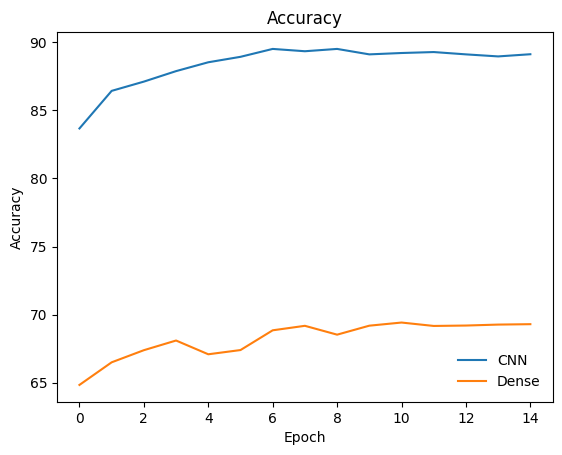

In [70]:
### INÍCIO DO CÓDIGO ### (≈ 2 linhas)
plt.plot(cnn_results['accuracy_list'], label='CNN') # plotando a acurácia da CNN
plt.plot(dense_results['accuracy_list'], label='Dense') # plotando a acurácia da rede densa
### FIM DO CÓDIGO ###

plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()

(Escreva sua resposta)

### Indo além... - Comparação de Resultados (sem ponto)

É possível plotar o gráfico de loss do treino e da validação para cada um dos modelos. Observe como os erros se comportam de maneira diferente para cada um dos subsets.

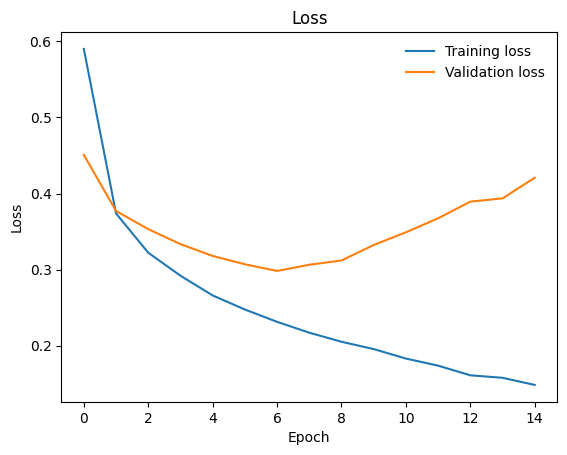

In [71]:
plt.plot(cnn_results['train_losses'], label='Training loss') # plotando a função de custo da CNN
plt.plot(cnn_results['test_losses'], label='Validation loss') # plotando a função de custo da CNN

plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

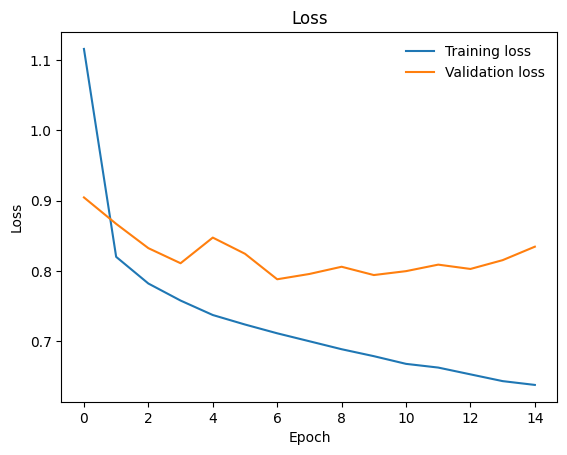

In [72]:
plt.plot(dense_results['train_losses'], label='Training loss') # plotando a função de custo da rede densa
plt.plot(dense_results['test_losses'], label='Validation loss') # plotando a função de custo da rede densa

plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()